In [183]:
import os
from pathlib import Path
import torch
from tqdm import tqdm
import warnings
import re
import keras
import librosa
import numpy as np
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

In [184]:
import soundfile as sf

### Use cuda acceleration (optional)

In [185]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [186]:
path = './AUDIO_DATA'

### Link your google drive storage if you are working on google colab (optional)  

In [187]:
path = '<your google drive path>'
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/DurianAudios

In [188]:

AUDIO_PATH = "./AUDIO_DATA"
AUDIO_LIST = list(map(lambda x: f"{AUDIO_PATH}/{x}", sorted(os.listdir(AUDIO_PATH))))
print(*AUDIO_LIST)

./AUDIO_DATA/20240929_023338_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023344_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023348_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023353_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023359_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023409_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023414_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023418_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023426_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023431_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023435_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023439_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023443_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023447_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023501_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023505_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023509_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023513_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023517_Dona_75-85%output.wav ./AUDIO_DATA/20240929_023521_Do

In [189]:

from sklearn.model_selection import train_test_split
# Séparer la liste AUDIO_LIST en train et test avant toute data augmentation
train_files, test_files = train_test_split(AUDIO_LIST, test_size=0.4, random_state=42, shuffle=True)
print(f"{len(train_files)} fichiers pour le train, {len(test_files)} pour le test.")


55 fichiers pour le train, 37 pour le test.


# **1. Data preparation**
---

In [190]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="PySoundFile failed.*")

audiosdir = AUDIO_PATH

audios_75_85 = []
audios_95 = []

def tri_audio(audio_name):
  if(audio_name not in [*audios_75_85,*audios_95]):
    try:
      if(re.split('_|%',audio_name)[3] == "75-85"):
        audios_75_85.append(audio_name)
      else:
        audios_95.append(audio_name)
    except :
      print(audio_name)
for i in sorted(os.listdir(audiosdir)):
  tri_audio(i)


In [191]:
def load_audio(file_name):
    if "aug" in file_name:
        full_path = os.path.join("augmented_train_dataset", file_name)
    else:
        full_path = os.path.join("AUDIO_DATA", file_name)
    y, sr = librosa.load(full_path, sr=None)
    return y, sr


In [192]:
path_good = sorted(Path("AUDIO_DATA").glob("*75-85%output.wav"))
path_bad = sorted(Path("AUDIO_DATA").glob("*95%output.wav"))

for p in [*path_good, *path_bad]:
    if not p.is_file():
        print(f"{p} NOT FOUND")

# **2. Data Augmentation**
---

In [193]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
    PitchShift(min_semitones=-1, max_semitones=1, p=0.5),
    Shift(min_shift=-0.1, max_shift=0.1, p=0.5)
])

In [194]:
out_path: str = "augmented_train_dataset"

In [195]:
!mkdir {out_path}

Un sous-r�pertoire ou un fichier augmented_train_dataset existe d�j�.


In [215]:
train_files

['./AUDIO_DATA/20240929_023807_Dona_95-Ripeoutput.wav',
 './AUDIO_DATA/20240929_023418_Dona_75-85%output.wav',
 './AUDIO_DATA/20240929_024422_Dona_75-85%output.wav',
 './AUDIO_DATA/20240929_023726_Dona_95-Ripeoutput.wav',
 './AUDIO_DATA/20240929_023521_Dona_75-85%output.wav',
 './AUDIO_DATA/20240929_024406_Dona_75-85%output.wav',
 './AUDIO_DATA/20240929_023718_Dona_95-Ripeoutput.wav',
 './AUDIO_DATA/20240929_023938_Dona_95-Ripeoutput.wav',
 './AUDIO_DATA/20240929_023447_Dona_75-85%output.wav',
 './AUDIO_DATA/20240929_023713_Dona_95-Ripeoutput.wav',
 './AUDIO_DATA/20240929_023353_Dona_75-85%output.wav',
 './AUDIO_DATA/20240929_023513_Dona_75-85%output.wav',
 './AUDIO_DATA/20240929_023823_Dona_95-Ripeoutput.wav',
 './AUDIO_DATA/20240929_023426_Dona_75-85%output.wav',
 './AUDIO_DATA/20240929_024345_Dona_95-Ripeoutput.wav',
 './AUDIO_DATA/20240929_023414_Dona_75-85%output.wav',
 './AUDIO_DATA/20240929_024510_Dona_75-85%output.wav',
 './AUDIO_DATA/20240929_023815_Dona_95-Ripeoutput.wav',
 '

In [196]:

out_path = "augmented_train_dataset"
os.makedirs(out_path, exist_ok=True)

nb_copies = 5  # nombre de copies augmentées par fichier

for file_name, (wave, sr) in tqdm ([(Path(audio_path).name, librosa.load(audio_path)) for audio_path in train_files]):
    for nb in range(nb_copies):
        wave_aug = augment(samples=wave, sample_rate=sr)
        out = os.path.join(out_path, f"{file_name}_aug{nb}.wav")
        sf.write(out, wave_aug, sr)


100%|██████████| 55/55 [00:24<00:00,  2.27it/s]


# **3. Data and features extraction : MFCC**
---

In [197]:

# Liste des fichiers augmentés
augmented_files = sorted(Path(out_path).glob("*.wav"))
# Les fichiers originaux du train
train_files_names = [Path(f).name for f in train_files]
# Les fichiers du test
test_files_names = [Path(f).name for f in test_files]
# Liste complète des fichiers d'entraînement (originaux + augmentés)
train_files_final = train_files_names + [f.name for f in augmented_files]

print(f"{len(train_files_final)} fichiers pour le train (originaux + augmentés)")
print(f"{len(test_files_names)} fichiers pour le test (non augmentés)")


330 fichiers pour le train (originaux + augmentés)
37 fichiers pour le test (non augmentés)


In [198]:
n_mfcc     = 40        # number of coefficients
n_fft      = 2048      # window size STFT
hop_length = 512

def compute_mfcc(lst: list):
  for fn in lst:
      y, sr = load_audio(fn)
      mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
      yield librosa.util.normalize(mfcc_features, axis=1)

In [199]:
mfcc_train = [*compute_mfcc(train_files_final)]
mfcc_test = [*compute_mfcc(test_files_names)]


# **4. Audio dataset preparation (padding and trimming)**
---

Besides, the idea is to set a single length T_max (typically the maximum recorded value) and then, for each MFCC:  
*   If T_i < T_max → pad with columns of trailing zeros
*   If T_i > T_max → trim to keep only the first T_max frames  

In [200]:
# Pour le train
T_train = [mfcc.shape[1] for mfcc in mfcc_train]
print("Durée (train) :", *T_train)

# Pour le test
T_test = [mfcc.shape[1] for mfcc in mfcc_test]
print("Durée (test) :", *T_test)

# T_max commun pour le padding (on prend le max des deux)
T_max = max(T_train + T_test)
print(f'The maximum value of time is {T_max} ms')

Durée (train) : 255 273 266 271 244 271 246 271 244 268 257 271 259 271 257 268 248 244 246 268 248 255 273 246 268 201 255 246 248 244 246 248 244 266 246 255 246 246 273 246 246 271 244 268 244 250 248 268 266 268 241 271 273 239 271 122 122 122 122 122 125 125 125 125 125 129 129 129 129 129 134 134 134 134 134 137 137 137 137 137 136 136 136 136 136 122 122 122 122 122 120 120 120 120 120 136 136 136 136 136 122 122 122 122 122 121 121 121 121 121 122 122 122 122 122 124 124 124 124 124 134 134 134 134 134 123 123 123 123 123 136 136 136 136 136 136 136 136 136 136 128 128 128 128 128 128 128 128 128 128 122 122 122 122 122 123 123 123 123 123 130 130 130 130 130 123 123 123 123 123 137 137 137 137 137 101 101 101 101 101 122 122 122 122 122 123 123 123 123 123 136 136 136 136 136 134 134 134 134 134 136 136 136 136 136 128 128 128 128 128 134 134 134 134 134 123 123 123 123 123 124 124 124 124 124 123 123 123 123 123 136 136 136 136 136 123 123 123 123 123 137 137 137 137 137 128 

In this step, we ensure that all MFCCs have the same length by either padding them with zeros or trimming them to a fixed length, `T_max`. This is necessary to standardize the input size for the model.

In [201]:
def pad_mfccs(mfcc_list, T_max):
    mfcc_fixed = []
    for m in mfcc_list:
        T_i = m.shape[1]
        if T_i < T_max:
            pad_width = T_max - T_i
            m2 = np.pad(m,
                        pad_width=((0,0),   # no padding sur les coefficients
                        (0,pad_width)),     # padding à droite sur le temps
                        mode='constant',
                        constant_values=0)
        else:
            m2 = m[:, :T_max]
        mfcc_fixed.append(m2)
    return mfcc_fixed

# Pour le train
mfcc_train_fixed = pad_mfccs(mfcc_train, T_max)

# Pour le test
mfcc_test_fixed = pad_mfccs(mfcc_test, T_max)


# **5. Dataset formatting for model input**
---
At this stage, we will prepare our padded/truncated MFCCs into the right shape for our deep learning model (flattening, stacking, or reshaping as needed), and associate them with their corresponding labels.


In [202]:
x_train = np.stack(mfcc_train_fixed, axis=0)[..., np.newaxis]
x_test = np.stack(mfcc_test_fixed, axis=0)[..., np.newaxis]

print("X_train.shape =", x_train.shape)
print("X_test.shape =", x_test.shape)


X_train.shape = (330, 40, 273, 1)
X_test.shape = (37, 40, 273, 1)


# **6. Label and shuffle**
---

In [203]:
def get_label(filename):
    if "75-85" in filename:
        return 0  # 0 pour unripe
    elif "95" in filename:
        return 1  # 1 pour ripe
    else:
        raise ValueError(f"Le nom de fichier ne permet pas d'extraire le label : {filename}")

for f in train_files_final[:5]:
    print(f, get_label(f))
for f in test_files_names[:5]:
    print(f, get_label(f))


y_train = np.array([get_label(f) for f in train_files_final])
y_test = np.array([get_label(f) for f in test_files_names])

print("y_train.shape =", y_train.shape)
print("y_test.shape =", y_test.shape)


20240929_023807_Dona_95-Ripeoutput.wav 1
20240929_023418_Dona_75-85%output.wav 0
20240929_024422_Dona_75-85%output.wav 0
20240929_023726_Dona_95-Ripeoutput.wav 1
20240929_023521_Dona_75-85%output.wav 0
20240929_023832_Dona_95-Ripeoutput.wav 1
20240929_023705_Dona_95-Ripeoutput.wav 1
20240929_023957_Dona_75-85%output.wav 0
20240929_024341_Dona_95-Ripeoutput.wav 1
20240929_023338_Dona_75-85%output.wav 0
y_train.shape = (330,)
y_test.shape = (37,)


Shuffle training data ton ensure linear accuracy progress during training

In [204]:
# Shuffle le train pour éviter tout biais
idx = np.arange(x_train.shape[0])
np.random.shuffle(idx)
x_train = x_train[idx]
y_train = y_train[idx]


# **7. Building the classification model**
---
Now let's define our deep learning model. We'll use a simple Convolutional Neural Network (CNN) architecture suitable for audio classification.


In [205]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Input, BatchNormalization, Dropout, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.utils import class_weight


In [206]:
model = Sequential([
    Input(shape=x_train.shape[1:]),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [207]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [208]:
def compile_model(model, learning_rate: int | None = None):
    if learning_rate is not None:
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return opt
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [209]:
compile_model(model)

# **6. Model training**
---
Let's train the model on the training data and keep track of its performance.


In [210]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = model.fit(
    x_train, y_train,
    epochs=60,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    shuffle=True,
)

Epoch 1/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - accuracy: 0.4855 - loss: 12.1725 - val_accuracy: 0.7121 - val_loss: 0.6726
Epoch 2/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.4825 - loss: 8.7466 - val_accuracy: 0.6364 - val_loss: 0.7111
Epoch 3/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6189 - loss: 2.8581 - val_accuracy: 0.6061 - val_loss: 1.2850
Epoch 4/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5626 - loss: 2.2542 - val_accuracy: 0.6061 - val_loss: 1.9697
Epoch 5/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.5561 - loss: 0.9170 - val_accuracy: 0.6061 - val_loss: 2.7043
Epoch 6/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6354 - loss: 0.5962 - val_accuracy: 0.6061 - val_loss: 3.5628


# **7. Model evaluation**
---
We now evaluate the trained model on the test set, check the accuracy, and display a confusion matrix for detailed analysis.


In [211]:
loss, acc = model.evaluate(x_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.4341 - loss: 0.7581


# **8. Results & analysis**
---
Let's analyze the results, discuss strengths and weaknesses, and try to interpret what the model is learning.


In [212]:
print("X_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

print("Répartition y_train :", np.unique(y_train, return_counts=True))
print("Répartition y_test :", np.unique(y_test, return_counts=True))

print("Premier fichier train:", train_files_final[0], "label:", y_train[0])
print("Premier fichier test:", test_files_names[0], "label:", y_test[0])

X_train.shape: (330, 40, 273, 1)
y_train.shape: (330,)
X_test.shape: (37, 40, 273, 1)
y_test.shape: (37,)
Répartition y_train : (array([0, 1]), array([180, 150]))
Répartition y_test : (array([0, 1]), array([15, 22]))
Premier fichier train: 20240929_023807_Dona_95-Ripeoutput.wav label: 1
Premier fichier test: 20240929_023832_Dona_95-Ripeoutput.wav label: 1


In [213]:
print("y_train repartition :", np.bincount(y_train))
print("y_test repartition :", np.bincount(y_test))

y_train repartition : [180 150]
y_test repartition : [15 22]


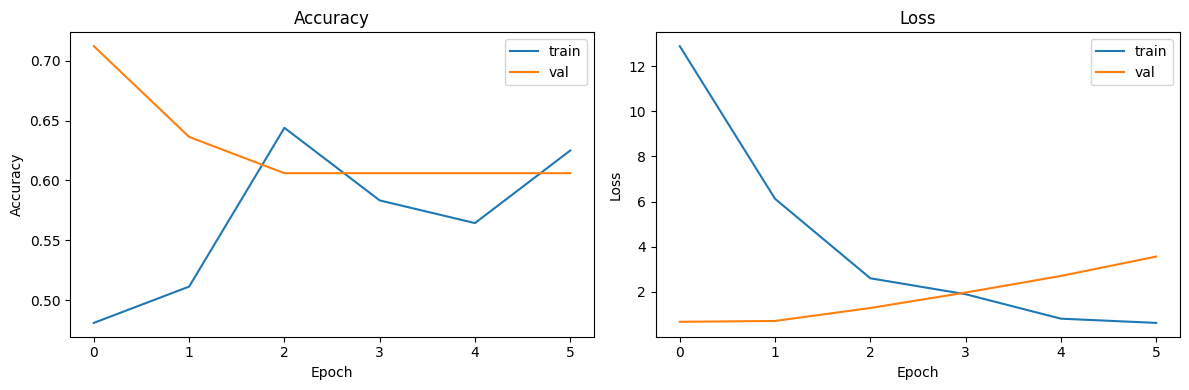

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 963ms/step


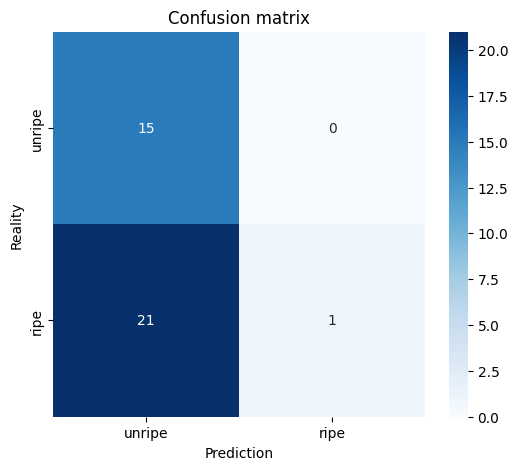

              precision    recall  f1-score   support

      unripe       0.42      1.00      0.59        15
        ripe       1.00      0.05      0.09        22

    accuracy                           0.43        37
   macro avg       0.71      0.52      0.34        37
weighted avg       0.76      0.43      0.29        37



In [214]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Confusion matrix
y_prob = model.predict(x_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ['unripe', 'ripe']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.title("Confusion matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))

